In [ ]:
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 KB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.6 MB/s eta 0:00:00


# Load data

In [ ]:
import pandas as pd

In [ ]:
# Train data
train = pd.read_csv('/content/drive/MyDrive/Image_forensics/final_project/sign_data/sign_data/train_data.csv')
train.rename(columns={"1":"label"}, inplace=True)
train["image_real_paths"] = train["068/09_068.png"].apply(lambda x: f"/content/drive/MyDrive/Image_forensics/final_project/sign_data/sign_data/train/{x}")
train["image_forged_paths"] = train["068_forg/03_0113068.PNG"].apply(lambda x: f"/content/drive/MyDrive/Image_forensics/final_project/sign_data/sign_data/train/{x}")

In [ ]:
# Test data
test = pd.read_csv('/content/drive/MyDrive/Image_forensics/final_project/sign_data/sign_data/test_data.csv')
test.rename(columns={"1":"label"}, inplace=True)
test["image_real_paths"] = test["068/09_068.png"].apply(lambda x: f"/content/drive/MyDrive/Image_forensics/final_project/sign_data/sign_data/test/{x}")
test["image_forged_paths"] = test["068_forg/03_0113068.PNG"].apply(lambda x: f"/content/drive/MyDrive/Image_forensics/final_project/sign_data/sign_data/test/{x}")

In [ ]:
train["label"].value_counts()

0    12602
1    10603
Name: label, dtype: int64

In [ ]:
test["label"].value_counts()

1    2975
0    2772
Name: label, dtype: int64

# Configuration

In [ ]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=128
    num_workers=2
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=15
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3,
        'steps_per_epoch':7, 
        'epochs':7
    }
    batch_size=16
    lr=1e-3
    weight_decay=1e-3
    canvas_size = (952, 1360)
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=train["label"].shape[0]
    nfolds=5
    trn_folds=[0]
    model_name='convnet'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'tresnet_m'
    train=True
    early_stop=True
    target_col="label"
    projection2d=False
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import wandb
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple

# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict


import scipy as sp

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


from torch.cuda.amp import autocast, GradScaler

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# utils

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="test-project", entity="img-research", 
                 name="convnet",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: Currently logged in as: samar-awad97 (img-research). Use `wandb login --relogin` to force relogin


In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = '/content/drive/MyDrive/Image_forensics/output_img_research'
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# Data Pre-processing

In [ ]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.
    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------
    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size
    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.
        Parameters
        ----------
        img : np.ndarray
            The image to be processed
        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size
    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images
        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    #plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray')
    plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [ ]:
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)

observation = train.iloc[10]
img1 = load_signature(observation["image_real_paths"])
img2 = load_signature(observation["image_forged_paths"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

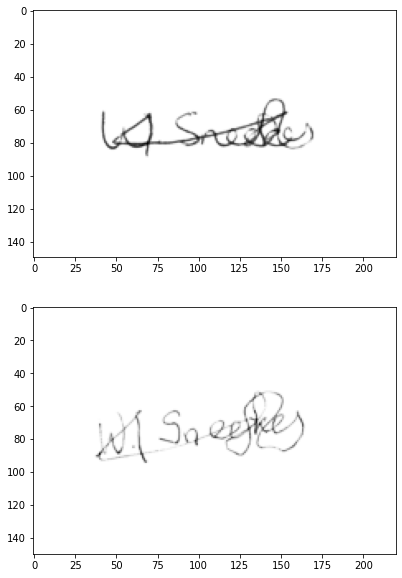

In [ ]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

# Dataset

In [ ]:
class SignatureDataset(Dataset):
    
    def __init__(self, df, canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["image_real_paths"].values
        self.forged_file_names = df["image_forged_paths"].values
        self.labels = df["label"].values
        self.dim = dim
        self.canvas_size=canvas_size

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]
        
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return torch.tensor(img1), torch.tensor(img2), label.float()

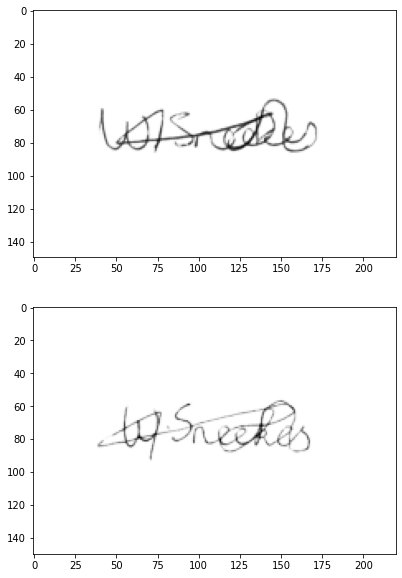

In [ ]:
train_dataset = SignatureDataset(train, canvas_size, input_size)
img1, img2, _ = train_dataset[1]

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)

# Contrastive loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(F.normalize(output1), F.normalize(output2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Models

In [ ]:
!unzip /content/drive/MyDrive/Image_forensics/signet.pth.zip -d /content/drive/MyDrive/Image_forensics

Archive:  /content/drive/MyDrive/Image_forensics/signet.pth.zip
  inflating: /content/drive/MyDrive/Image_forensics/signet.pth  


In [ ]:
class SigNet(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))
    
    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.Mish()),
    ]))

class SiameseModel(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.model = SigNet()
        state_dict, _, _ = torch.load("/content/drive/MyDrive/Image_forensics/signet.pth")
        self.model.load_state_dict(state_dict)
        
        if CFG.projection2d:
            self.probs = nn.Linear(4, 1)
        else:
            self.probs = nn.Linear(self.model.feature_space_size*2, 1)
        self.projection2d = nn.Linear(self.model.feature_space_size, 2)
    
    def forward_once(self, img):
        x = self.model.forward_once(img)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        # forward pass of input 1
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        embedding1 = self.forward_once(img1)
        # forward pass of input 2
        embedding2 = self.forward_once(img2)
        
        if CFG.projection2d:
            print("Project embeddings into 2d space")
            embedding1 = self.projection2d(embedding1)
            embedding2 = self.projection2d(embedding2)
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output
        else:
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.Mish()),
    ]))

# Helper functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterions, optimizer, epoch, scheduler, device):
    
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (img1, img2, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        out1, out2, preds = model(img1, img2)
        loss1 = criterions[0](out1, out2, labels)
        loss2 = criterions[1](preds.squeeze(1), labels)
        loss = (loss1 + loss2) / 2
            
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print(f'Epoch: [{epoch}][{step}/{len(train_loader)}] ', end='')
            print(f'Elapsed: {timeSince(start, float(step+1)/len(train_loader))} ', end='')
            print(f'Loss: {losses.val:.4f}({losses.avg:.4f}) ', end='')
            print(f'Grad: {grad_norm:.4f} ', end='')
            if scheduler:
                print(f'LR: {scheduler.get_last_lr()[0]:.6f}  ')
            else:
                print(f'LR: {CFG.lr}')
            
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
    return losses.avg

# train

In [ ]:
# ====================================================
# loader
# ====================================================
seed_torch(seed=CFG.seed)


train_dataset = SignatureDataset(train, CFG.canvas_size, dim=(256, 256))

train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
   
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
    return scheduler

# ====================================================
# model & optimizer
# ====================================================
model = SiameseModel()
model.to(device)
# Optional
wandb.watch(model) 

optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
try:
    scheduler = get_scheduler(optimizer)
except:
    print('Learning scheduler is not used')

# ====================================================
# loop
# ====================================================
contrastive = ContrastiveLoss() # Contrastive loss
binary_cross = nn.BCEWithLogitsLoss() # Binary cross entropy
best_score = 0.
best_loss = np.inf
    
for epoch in range(CFG.epochs):
        
    start_time = time.time()
        
    # train
    avg_loss = train_fn(train, train_loader, model, [contrastive, binary_cross], optimizer, epoch, scheduler, device)

        
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, OneCycleLR):
        scheduler.step()


    elapsed = time.time() - start_time

    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
    wandb.log({f"epoch": epoch+1, 
                   f"avg_train_loss": avg_loss})
                 
            
    if avg_loss < best_loss:
        best_loss = avg_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict()}, 
                        OUTPUT_DIR+f'{CFG.model_name}_best_loss.pt')
   
   
wandb.finish()

Epoch: [0][0/1450] Elapsed: 0m 16s (remain 405m 20s) Loss: 0.5392(0.5392) Grad: 4.2005 LR: 0.001000  
Epoch: [0][100/1450] Elapsed: 4m 48s (remain 64m 7s) Loss: 0.5449(0.4120) Grad: 3.9115 LR: 0.001000  
Epoch: [0][200/1450] Elapsed: 8m 0s (remain 49m 45s) Loss: 0.2267(0.3623) Grad: 1.3304 LR: 0.001000  
Epoch: [0][300/1450] Elapsed: 10m 59s (remain 41m 56s) Loss: 0.2668(0.3364) Grad: 1.7620 LR: 0.001000  
Epoch: [0][400/1450] Elapsed: 13m 57s (remain 36m 30s) Loss: 0.1432(0.3091) Grad: 0.8869 LR: 0.001000  
Epoch: [0][500/1450] Elapsed: 16m 51s (remain 31m 56s) Loss: 0.1023(0.2836) Grad: 1.4872 LR: 0.001000  
Epoch: [0][600/1450] Elapsed: 19m 46s (remain 27m 56s) Loss: 0.0503(0.2650) Grad: 0.6677 LR: 0.001000  
Epoch: [0][700/1450] Elapsed: 22m 38s (remain 24m 11s) Loss: 0.1407(0.2486) Grad: 1.1061 LR: 0.001000  
Epoch: [0][800/1450] Elapsed: 25m 33s (remain 20m 42s) Loss: 0.0836(0.2341) Grad: 1.5168 LR: 0.001000  
Epoch: [0][900/1450] Elapsed: 28m 27s (remain 17m 20s) Loss: 0.1055(0.

Epoch 1 - avg_train_loss: 0.1721  time: 2664s
INFO:__main__:Epoch 1 - avg_train_loss: 0.1721  time: 2664s
Epoch 1 - Save Best Loss: 0.1721 Model
INFO:__main__:Epoch 1 - Save Best Loss: 0.1721 Model


Epoch: [0][1449/1450] Elapsed: 44m 23s (remain 0m 0s) Loss: 0.0296(0.1721) Grad: 0.3538 LR: 0.001000  
Epoch: [1][0/1450] Elapsed: 0m 3s (remain 94m 14s) Loss: 0.1067(0.1067) Grad: 1.1373 LR: 0.000855  
Epoch: [1][100/1450] Elapsed: 2m 57s (remain 39m 31s) Loss: 0.0948(0.0857) Grad: 1.1097 LR: 0.000855  
Epoch: [1][200/1450] Elapsed: 5m 51s (remain 36m 27s) Loss: 0.0419(0.0824) Grad: 0.9511 LR: 0.000855  
Epoch: [1][300/1450] Elapsed: 8m 49s (remain 33m 39s) Loss: 0.0257(0.0753) Grad: 0.5916 LR: 0.000855  
Epoch: [1][400/1450] Elapsed: 11m 43s (remain 30m 39s) Loss: 0.0869(0.0727) Grad: 1.6127 LR: 0.000855  
Epoch: [1][500/1450] Elapsed: 14m 40s (remain 27m 47s) Loss: 0.0241(0.0685) Grad: 0.4555 LR: 0.000855  
Epoch: [1][600/1450] Elapsed: 17m 35s (remain 24m 50s) Loss: 0.0339(0.0677) Grad: 0.4713 LR: 0.000855  
Epoch: [1][700/1450] Elapsed: 20m 30s (remain 21m 55s) Loss: 0.0662(0.0675) Grad: 1.0186 LR: 0.000855  
Epoch: [1][800/1450] Elapsed: 23m 24s (remain 18m 57s) Loss: 0.0316(0.06

Epoch 2 - avg_train_loss: 0.0628  time: 2532s
INFO:__main__:Epoch 2 - avg_train_loss: 0.0628  time: 2532s
Epoch 2 - Save Best Loss: 0.0628 Model
INFO:__main__:Epoch 2 - Save Best Loss: 0.0628 Model


Epoch: [1][1449/1450] Elapsed: 42m 11s (remain 0m 0s) Loss: 0.0318(0.0628) Grad: 0.7271 LR: 0.000855  
Epoch: [2][0/1450] Elapsed: 0m 3s (remain 86m 17s) Loss: 0.0191(0.0191) Grad: 0.3023 LR: 0.000505  
Epoch: [2][100/1450] Elapsed: 2m 55s (remain 39m 2s) Loss: 0.0253(0.0449) Grad: 0.4146 LR: 0.000505  
Epoch: [2][200/1450] Elapsed: 5m 48s (remain 36m 5s) Loss: 0.0223(0.0427) Grad: 0.3972 LR: 0.000505  
Epoch: [2][300/1450] Elapsed: 8m 45s (remain 33m 25s) Loss: 0.0133(0.0365) Grad: 0.2515 LR: 0.000505  
Epoch: [2][400/1450] Elapsed: 11m 41s (remain 30m 33s) Loss: 0.0107(0.0327) Grad: 0.1637 LR: 0.000505  
Epoch: [2][500/1450] Elapsed: 14m 35s (remain 27m 39s) Loss: 0.0176(0.0319) Grad: 0.3699 LR: 0.000505  
Epoch: [2][600/1450] Elapsed: 17m 33s (remain 24m 48s) Loss: 0.2208(0.0323) Grad: 3.6049 LR: 0.000505  
Epoch: [2][700/1450] Elapsed: 20m 27s (remain 21m 51s) Loss: 0.0240(0.0313) Grad: 0.2693 LR: 0.000505  
Epoch: [2][800/1450] Elapsed: 23m 21s (remain 18m 55s) Loss: 0.0321(0.0305

Epoch 3 - avg_train_loss: 0.0300  time: 2550s
INFO:__main__:Epoch 3 - avg_train_loss: 0.0300  time: 2550s
Epoch 3 - Save Best Loss: 0.0300 Model
INFO:__main__:Epoch 3 - Save Best Loss: 0.0300 Model


Epoch: [2][1449/1450] Elapsed: 42m 29s (remain 0m 0s) Loss: 0.0361(0.0300) Grad: 0.9266 LR: 0.000505  
Epoch: [3][0/1450] Elapsed: 0m 3s (remain 92m 40s) Loss: 0.0269(0.0269) Grad: 0.4700 LR: 0.000155  
Epoch: [3][100/1450] Elapsed: 3m 0s (remain 40m 13s) Loss: 0.0193(0.0280) Grad: 0.3122 LR: 0.000155  
Epoch: [3][200/1450] Elapsed: 5m 56s (remain 36m 52s) Loss: 0.0539(0.0230) Grad: 1.7450 LR: 0.000155  
Epoch: [3][300/1450] Elapsed: 8m 49s (remain 33m 39s) Loss: 0.0058(0.0222) Grad: 0.1786 LR: 0.000155  
Epoch: [3][400/1450] Elapsed: 11m 44s (remain 30m 42s) Loss: 0.0111(0.0210) Grad: 0.2486 LR: 0.000155  
Epoch: [3][500/1450] Elapsed: 14m 38s (remain 27m 44s) Loss: 0.0085(0.0195) Grad: 0.2579 LR: 0.000155  
Epoch: [3][600/1450] Elapsed: 17m 33s (remain 24m 47s) Loss: 0.0211(0.0184) Grad: 0.4661 LR: 0.000155  
Epoch: [3][700/1450] Elapsed: 20m 32s (remain 21m 57s) Loss: 0.0180(0.0178) Grad: 0.5581 LR: 0.000155  
Epoch: [3][800/1450] Elapsed: 23m 28s (remain 19m 0s) Loss: 0.0158(0.0175

Epoch 4 - avg_train_loss: 0.0173  time: 2556s
INFO:__main__:Epoch 4 - avg_train_loss: 0.0173  time: 2556s
Epoch 4 - Save Best Loss: 0.0173 Model
INFO:__main__:Epoch 4 - Save Best Loss: 0.0173 Model


Epoch: [3][1449/1450] Elapsed: 42m 35s (remain 0m 0s) Loss: 0.0317(0.0173) Grad: 1.1707 LR: 0.000155  
Epoch: [4][0/1450] Elapsed: 0m 3s (remain 88m 47s) Loss: 0.0096(0.0096) Grad: 0.2023 LR: 0.000010  
Epoch: [4][100/1450] Elapsed: 2m 55s (remain 39m 4s) Loss: 0.0052(0.0138) Grad: 0.1526 LR: 0.000010  
Epoch: [4][200/1450] Elapsed: 5m 51s (remain 36m 22s) Loss: 0.0034(0.0128) Grad: 0.1176 LR: 0.000010  
Epoch: [4][300/1450] Elapsed: 8m 43s (remain 33m 17s) Loss: 0.0049(0.0126) Grad: 0.1336 LR: 0.000010  
Epoch: [4][400/1450] Elapsed: 11m 36s (remain 30m 21s) Loss: 0.0044(0.0124) Grad: 0.1388 LR: 0.000010  
Epoch: [4][500/1450] Elapsed: 14m 29s (remain 27m 27s) Loss: 0.0171(0.0121) Grad: 0.3925 LR: 0.000010  
Epoch: [4][600/1450] Elapsed: 17m 19s (remain 24m 29s) Loss: 0.0109(0.0127) Grad: 0.3738 LR: 0.000010  
Epoch: [4][700/1450] Elapsed: 20m 15s (remain 21m 39s) Loss: 0.0092(0.0126) Grad: 0.1524 LR: 0.000010  
Epoch: [4][800/1450] Elapsed: 23m 12s (remain 18m 48s) Loss: 0.0340(0.012

Epoch 5 - avg_train_loss: 0.0127  time: 2521s
INFO:__main__:Epoch 5 - avg_train_loss: 0.0127  time: 2521s
Epoch 5 - Save Best Loss: 0.0127 Model
INFO:__main__:Epoch 5 - Save Best Loss: 0.0127 Model


Epoch: [4][1449/1450] Elapsed: 42m 0s (remain 0m 0s) Loss: 0.0038(0.0127) Grad: 0.0566 LR: 0.000010  
Epoch: [5][0/1450] Elapsed: 0m 3s (remain 84m 28s) Loss: 0.0116(0.0116) Grad: 0.2674 LR: 0.000155  
Epoch: [5][100/1450] Elapsed: 2m 54s (remain 38m 56s) Loss: 0.0158(0.0251) Grad: 0.2568 LR: 0.000155  
Epoch: [5][200/1450] Elapsed: 5m 54s (remain 36m 40s) Loss: 0.0117(0.0199) Grad: 0.2267 LR: 0.000155  
Epoch: [5][300/1450] Elapsed: 8m 49s (remain 33m 42s) Loss: 0.0307(0.0189) Grad: 0.5468 LR: 0.000155  
Epoch: [5][400/1450] Elapsed: 11m 46s (remain 30m 48s) Loss: 0.0028(0.0173) Grad: 0.0761 LR: 0.000155  
Epoch: [5][500/1450] Elapsed: 14m 42s (remain 27m 50s) Loss: 0.0047(0.0165) Grad: 0.0777 LR: 0.000155  
Epoch: [5][600/1450] Elapsed: 17m 35s (remain 24m 51s) Loss: 0.0223(0.0159) Grad: 1.0032 LR: 0.000155  
Epoch: [5][700/1450] Elapsed: 20m 27s (remain 21m 51s) Loss: 0.0088(0.0153) Grad: 0.1964 LR: 0.000155  
Epoch: [5][800/1450] Elapsed: 23m 20s (remain 18m 54s) Loss: 0.0061(0.015

Epoch 6 - avg_train_loss: 0.0141  time: 2516s
INFO:__main__:Epoch 6 - avg_train_loss: 0.0141  time: 2516s


Epoch: [5][1449/1450] Elapsed: 41m 55s (remain 0m 0s) Loss: 0.0079(0.0141) Grad: 0.2348 LR: 0.000155  
Epoch: [6][0/1450] Elapsed: 0m 3s (remain 80m 42s) Loss: 0.0103(0.0103) Grad: 0.2779 LR: 0.000505  
Epoch: [6][100/1450] Elapsed: 2m 55s (remain 39m 3s) Loss: 0.1148(0.1087) Grad: 3.7664 LR: 0.000505  
Epoch: [6][200/1450] Elapsed: 5m 47s (remain 36m 0s) Loss: 0.6002(0.0845) Grad: 3.7138 LR: 0.000505  
Epoch: [6][300/1450] Elapsed: 8m 37s (remain 32m 54s) Loss: 0.0251(0.0749) Grad: 0.3476 LR: 0.000505  
Epoch: [6][400/1450] Elapsed: 11m 28s (remain 30m 1s) Loss: 0.0312(0.0651) Grad: 0.4659 LR: 0.000505  
Epoch: [6][500/1450] Elapsed: 14m 20s (remain 27m 10s) Loss: 0.0099(0.0600) Grad: 0.2104 LR: 0.000505  
Epoch: [6][600/1450] Elapsed: 17m 13s (remain 24m 20s) Loss: 0.0275(0.0531) Grad: 0.4441 LR: 0.000505  
Epoch: [6][700/1450] Elapsed: 20m 8s (remain 21m 31s) Loss: 0.0130(0.0488) Grad: 0.3063 LR: 0.000505  
Epoch: [6][800/1450] Elapsed: 23m 8s (remain 18m 45s) Loss: 0.0085(0.0468) G

Epoch 7 - avg_train_loss: 0.0359  time: 2514s
INFO:__main__:Epoch 7 - avg_train_loss: 0.0359  time: 2514s


Epoch: [6][1449/1450] Elapsed: 41m 53s (remain 0m 0s) Loss: 0.0372(0.0359) Grad: 1.5894 LR: 0.000505  
Epoch: [7][0/1450] Elapsed: 0m 5s (remain 120m 52s) Loss: 0.0301(0.0301) Grad: 0.7145 LR: 0.000855  
Epoch: [7][100/1450] Elapsed: 2m 56s (remain 39m 20s) Loss: 0.0156(0.0687) Grad: 0.3032 LR: 0.000855  
Epoch: [7][200/1450] Elapsed: 5m 46s (remain 35m 52s) Loss: 0.1071(0.0525) Grad: 3.2767 LR: 0.000855  
Epoch: [7][300/1450] Elapsed: 8m 41s (remain 33m 11s) Loss: 0.0341(0.0488) Grad: 1.0874 LR: 0.000855  
Epoch: [7][400/1450] Elapsed: 11m 34s (remain 30m 16s) Loss: 0.0247(0.0459) Grad: 0.5848 LR: 0.000855  
Epoch: [7][500/1450] Elapsed: 14m 26s (remain 27m 21s) Loss: 0.0457(0.0444) Grad: 1.2715 LR: 0.000855  
Epoch: [7][600/1450] Elapsed: 17m 14s (remain 24m 21s) Loss: 0.0231(0.0495) Grad: 0.5125 LR: 0.000855  
Epoch: [7][700/1450] Elapsed: 20m 6s (remain 21m 29s) Loss: 0.0283(0.0468) Grad: 0.8279 LR: 0.000855  
Epoch: [7][800/1450] Elapsed: 22m 57s (remain 18m 36s) Loss: 0.0201(0.04

Epoch 8 - avg_train_loss: 0.0335  time: 2555s
INFO:__main__:Epoch 8 - avg_train_loss: 0.0335  time: 2555s


Epoch: [7][1449/1450] Elapsed: 42m 34s (remain 0m 0s) Loss: 0.0154(0.0335) Grad: 0.4921 LR: 0.000855  
Epoch: [8][0/1450] Elapsed: 0m 4s (remain 99m 35s) Loss: 0.0279(0.0279) Grad: 0.8568 LR: 0.001000  
Epoch: [8][100/1450] Elapsed: 3m 3s (remain 40m 44s) Loss: 0.0535(0.0860) Grad: 1.0688 LR: 0.001000  
Epoch: [8][200/1450] Elapsed: 6m 1s (remain 37m 28s) Loss: 0.0476(0.0651) Grad: 0.8321 LR: 0.001000  
Epoch: [8][300/1450] Elapsed: 9m 0s (remain 34m 23s) Loss: 0.0257(0.0619) Grad: 0.2859 LR: 0.001000  
Epoch: [8][400/1450] Elapsed: 11m 56s (remain 31m 14s) Loss: 0.0092(0.0567) Grad: 0.2400 LR: 0.001000  
Epoch: [8][500/1450] Elapsed: 14m 52s (remain 28m 11s) Loss: 0.0401(0.0539) Grad: 0.7133 LR: 0.001000  
